We start importing spark and creating a session. findspark makes it easy to create the session with minimal configuration

In [1]:
import findspark
findspark.init('/home/ec2-user/spark-2.4.0-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('house-price-pred').getOrCreate()

Read data source from the AWS S3 bucket. format() accepts 'json', 'csv', 'txt'

In [2]:
housing_df = spark.read.format('csv').option('header', 'True').option('inferSchema', 'True').load('s3a://capstone-house-prices/propattributes.csv')

# how many rows and columns?
print('dataframe rows: ', housing_df.count())
print('columns: ', len(housing_df.columns))

dataframe rows:  4413212
columns:  73


In [3]:
# take a look at the schema
housing_df.printSchema()

root
 |-- fips_cd: integer (nullable = true)
 |-- apn: string (nullable = true)
 |-- IsTraining: integer (nullable = true)
 |-- prop_house_number: string (nullable = true)
 |-- prop_house_number_2: string (nullable = true)
 |-- prop_house_number_suffix: string (nullable = true)
 |-- prop_direction_left: string (nullable = true)
 |-- prop_street_name: string (nullable = true)
 |-- prop_suffix: string (nullable = true)
 |-- prop_direction_right: string (nullable = true)
 |-- prop_unit_type: string (nullable = true)
 |-- prop_unit_number: string (nullable = true)
 |-- prop_city: string (nullable = true)
 |-- prop_state: string (nullable = true)
 |-- prop_zip_code: integer (nullable = true)
 |-- prop_zip_plus_4: integer (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- zoning: string (nullable = true)
 |-- census_tract: integer (nullable = true)
 |-- mobile_home_ind: string (nullable = true)
 |-- timeshare_ind: string (nullable = true)
 |-- acres: double (nullable = true)

Notice right at the end of the schema that transaction_date is a STRING feature as oppossed to DATE or DATETIME. We have to fix that

In [4]:
# find out how the transaction_date feature represents dates, and whether if it contains nulls or not.
housing_df.groupBy('transaction_date').count().orderBy('count', ascending=False).show(5)

+----------------+-----+
|transaction_date|count|
+----------------+-----+
|        06/30/06| 5773|
|        06/29/07| 5387|
|        04/28/06| 5217|
|        06/28/13| 4977|
|        09/29/06| 4864|
+----------------+-----+
only showing top 5 rows



It looks like standard date for the US: month/day/year

In [5]:
# we'll create a new column sale_date casted as DATETYPE
from pyspark.sql.types import StringType, DoubleType, IntegerType, DateType
from pyspark.sql.functions import from_unixtime, unix_timestamp, to_timestamp

housing_df = housing_df.withColumn('sale_date', from_unixtime(unix_timestamp('transaction_date', 'MM/dd/yy')).cast(DateType()))
housing_df.select('apn','transaction_date','sale_date').show(10)

+-----------------+----------------+----------+
|              apn|transaction_date| sale_date|
+-----------------+----------------+----------+
|09 E12-0054---000|        04/07/16|2016-04-07|
|09 E12-0054---000|        07/12/17|2017-07-12|
|09 E12-0054---000|        06/03/15|2015-06-03|
|09 E12-0054---000|        06/30/08|2008-06-30|
|08 008-0271---000|        05/26/10|2010-05-26|
|08 031-0092---000|        04/12/04|2004-04-12|
|09 E12-0055---000|        02/28/17|2017-02-28|
|08 021-0017---000|        10/20/17|2017-10-20|
|08 008-0272---000|        08/31/12|2012-08-31|
|09 E12-0057---000|        09/15/17|2017-09-15|
+-----------------+----------------+----------+
only showing top 10 rows



This dataset contains geographic coordinates. It makes sense to map those datapoints and see if we find something unusual. First, find out if we have null values.

In [6]:
housing_df.groupBy('geocode_latitude').count().orderBy('count', ascending=False).show(5)

+----------------+------+
|geocode_latitude| count|
+----------------+------+
|            null|724560|
|       40.991199|  1752|
|       41.077272|  1492|
|       41.178551|  1347|
|       41.116405|  1287|
+----------------+------+
only showing top 5 rows



More than 700 thousand missing values!
Let's just label them for the moment. The map will give us more information. 
Creating a new column lat_imputed=1 if the value on geocode_latitude is NULL, otherwise lat_imputed=0. We do the same for geocode_longitude.

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf, when

# create lat-long_imputed column
housing_df = housing_df.select(col('*'), F.when(housing_df['geocode_latitude'].isNull(), 1).otherwise(0).alias('lat_imputed'))
housing_df = housing_df.select(col('*'), F.when(housing_df['geocode_longitude'].isNull(), 1).otherwise(0).alias('lng_imputed'))
                                
# filling nulls with 0's
housing_df = housing_df.select(col('*'), F.when(housing_df['geocode_latitude'].isNull(), 0).otherwise(housing_df['geocode_latitude']).alias('latitude'))
housing_df = housing_df.select(col('*'), F.when(housing_df['geocode_longitude'].isNull(), 0).otherwise(housing_df['geocode_longitude']).alias('longitude'))

Another important feature IsTraining. It indicates whether we can or cannot use the data for training of our machine learning model.
Let's create two dataframes: training and validation.

In [8]:
housing_train = housing_df.select(col('*')).where(col('IsTraining')==1)
housing_validate = housing_df.select(col('*')).where(col('IsTraining')==0)

print('Training dataframe rows: ', housing_train.count())
print('columns: ', len(housing_train.columns))

print('Validation dataframe rows: ', housing_validate.count())
print('columns: ', len(housing_validate.columns))

Training dataframe rows:  2203046
columns:  78
Validation dataframe rows:  2210166
columns:  78


For visualization purposes we'll use pandas, matplotlib and seaborn. Note: the .toPandas() function uses ApacheArrow to convert the Spark Dataframe to a Pandas DataFrame. The spark.conf lines below will configure Arrow dynamically after installing it from terminal with "pip install pyarrow". Notebook restart not needed.

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

spark.conf.set('spark.sql.execution.arrow.enabled', 'true')
spark.conf.set('spark.sql.execution.arrow.fallback.enabled', 'true')
pd.options.display.max_columns = 100

pd_train = housing_train.select('*').toPandas()
pd_validate = housing_validate.select('*').toPandas()
pd_train[:5]

,fips_cd,apn,IsTraining,prop_house_number,prop_house_number_2,prop_house_number_suffix,prop_direction_left,prop_street_name,prop_suffix,prop_direction_right,prop_unit_type,prop_unit_number,prop_city,prop_state,prop_zip_code,prop_zip_plus_4,dwelling_type,zoning,census_tract,mobile_home_ind,timeshare_ind,acres,land_square_footage,irregular_lot_flg,assessed_total_value,assessed_land_value,assessed_improvement_value,market_total_value,market_land_value,market_improvement_value,tax_amt,tax_year,delinquent_tax_year,assessed_year,tax_cd_area,building_square_feet,total_living_square_feet,total_ground_floor_square_feet,total_basement_square_feet,total_garage_parking_square_feet,year_built,effective_year_built,bedrooms,total_rooms,total_baths_calculated,air_conditioning,basement_cd,condition,construction_type,fireplace_num,garage_type,heating_type,construction_quality,roof_cover,roof_type,stories_cd,style,geocode_latitude,geocode_longitude,avm_final_value0,avm_std_deviation0,avm_final_value1,avm_std_deviation1,avm_final_value2,avm_std_deviation2,avm_final_value3,avm_std_deviation3,avm_final_value4,avm_std_deviation4,first_mtg_amt,distressed_sale_flg,sale_amt,transaction_date,sale_date,lat_imputed,lng_imputed,latitude,longitude
0,42001,09 E12-0054---000,1,190,None,None,None,KNOXLYN,RD,None,None,None,GETTYSBURG,PA,17325.0,7413.0,Single Family Residential,None,31401.0,None,None,0.62,27007,None,177600.0,54500.0,123100.0,177600.0,54500.0,123100.0,304.69,2018,0,2018,GERRYSBURG,1242,1242,0,0,324,1968,1968,3,7,2,Central,Partial Basement,None,None,1,Attached Garage,Heat Pump,None,None,None,None,None,39.845495,-77.285247,183500.0,0.17,183900.0,0.22,184000.0,0.21,186000.0,0.24,200071.0,0.2256,0.0,Y,108000.0,04/07/16,2016-04-07,0,0,39.845495,-77.285247
1,42001,09 E12-0054---000,1,190,None,None,None,KNOXLYN,RD,None,None,None,GETTYSBURG,PA,17325.0,7413.0,Single Family Residential,None,31401.0,None,None,0.62,27007,None,177600.0,54500.0,123100.0,177600.0,54500.0,123100.0,304.69,2018,0,2018,GERRYSBURG,1242,1242,0,0,324,1968,1968,3,7,2,Central,Partial Basement,None,None,1,Attached Garage,Heat Pump,None,None,None,None,None,39.845495,-77.285247,183500.0,0.17,183900.0,0.22,184000.0,0.21,186000.0,0.24,200071.0,0.2256,202022.0,Y,205750.0,07/12/17,2017-07-12,0,0,39.845495,-77.285247
2,42001,09 E12-0054---000,1,190,None,None,None,KNOXLYN,RD,None,None,None,GETTYSBURG,PA,17325.0,7413.0,Single Family Residential,None,31401.0,None,None,0.62,27007,None,177600.0,54500.0,123100.0,177600.0,54500.0,123100.0,304.69,2018,0,2018,GERRYSBURG,1242,1242,0,0,324,1968,1968,3,7,2,Central,Partial Basement,None,None,1,Attached Garage,Heat Pump,None,None,None,None,None,39.845495,-77.285247,183500.0,0.17,183900.0,0.22,184000.0,0.21,186000.0,0.24,200071.0,0.2256,0.0,None,2177.0,06/03/15,2015-06-03,0,0,39.845495,-77.285247
3,42001,09 E12-0054---000,1,190,None,None,None,KNOXLYN,RD,None,None,None,GETTYSBURG,PA,17325.0,7413.0,Single Family Residential,None,31401.0,None,None,0.62,27007,None,177600.0,54500.0,123100.0,177600.0,54500.0,123100.0,304.69,2018,0,2018,GERRYSBURG,1242,1242,0,0,324,1968,1968,3,7,2,Central,Partial Basement,None,None,1,Attached Garage,Heat Pump,None,None,None,None,None,39.845495,-77.285247,183500.0,0.17,183900.0,0.22,184000.0,0.21,186000.0,0.24,200071.0,0.2256,196910.0,Y,200000.0,06/30/08,2008-06-30,0,0,39.845495,-77.285247
4,42001,08 008-0271---000,1,112,None,None,S,JEFFERSON,ST,None,None,None,HANOVER,PA,17331.0,4801.0,Single Family Residential,None,31101.0,None,None,0.12,5227,None,132600.0,21100.0,111500.0,132600.0,21100.0,111500.0,2498.37,2018,0,2018,CONEWAGO V,1248,1248,0,0,324,1968,1968,2,4,1,Central,Full Basement,None,None,0,Attached Garage,Forced air unit,None,None,None,None,None,39.803994,-77.005952,151000.0,0.10,151600.0,0.13,147000.0,0.14,148000.0,0.19,131061.0,0.2285,128075.0,Y,129800.0,05/26/10,2010-05-26,0,0,39.803994,-77.005952


We are ready to map our data. A heatmap will show us data concentration

In [10]:
import folium
from folium import plugins

# dataFrame for heatmap
#resample_df = pd_train.sample(n=68000, random_state=12345)
map_df = pd.DataFrame({
    'state': pd_train['prop_state']
    ,'square': pd_train['building_square_feet']
    ,'mkt': pd_train['market_total_value']
    ,'sale': pd_train['sale_amt']
    ,'geo_imp': pd_train['lat_imputed']
    ,'lat': pd_train['latitude']
    ,'lng': pd_train['longitude']})

housing_heatmap = folium.Map([37, -97], tiles='Cartodb Positron', zoom_start=4)
housing_heatmap.add_child(plugins.HeatMap(map_df[['lat','lng']].values))
housing_heatmap.save('housing_heatmap.html')

from IPython.display import IFrame
IFrame("housing_heatmap.html", width=720, height=405)

That's odd. We were expecting to see only data from three states. For sure Texas and Florida were not included!

Let's take a look at properties on each state.

In [11]:
# get all the unique values from prop_state and create lists for new dataframe
state = map_df['state'].value_counts().keys().tolist()
state_lat = []
state_lng = []
state_count = []

# filter train dataframe. removing rows with null values so it won't affect mean calculation of latitude and longitude
lat_not_null = (map_df['geo_imp']==0)
pd_tmp = map_df[lat_not_null]

# filter again temporary dataframe so each iteration gets data for the corresponding state
for each in state:
    is_state_mask = (pd_tmp['state']==each)
    pd_state = pd_tmp[is_state_mask]
    state_lat.append(pd_state['lat'].mean())
    state_lng.append(pd_state['lng'].mean())
    state_count.append(pd_state['state'].count())
    
# dataframe for bubble map
bubble_data = pd.DataFrame({
   'lat':state_lat,
   'lng':state_lng,
   'state':state,
   'counts':state_count
})

# create map adding bubbles per each state
bubble_map = folium.Map(location=[41, -75], tiles='Cartodb Positron', zoom_start=6)
for i in range(0,len(bubble_data)):
   folium.Circle(
      location=[bubble_data.iloc[i]['lat'], bubble_data.iloc[i]['lng']],
      popup=folium.Popup("{0}: {1}".format(bubble_data.iloc[i]['state'], bubble_data.iloc[i]['counts']), show=False),
      radius=bubble_data.iloc[i]['counts']*0.2,
      color='DarkOrange',
      fill=True,
      fill_color='DarkOrange'
   ).add_to(bubble_map) 
bubble_map.save('bubble_map.html')

# show map inside a frame
IFrame('bubble_map.html', width=720, height=405)

This is a case where a simple bar plot is much more effective.

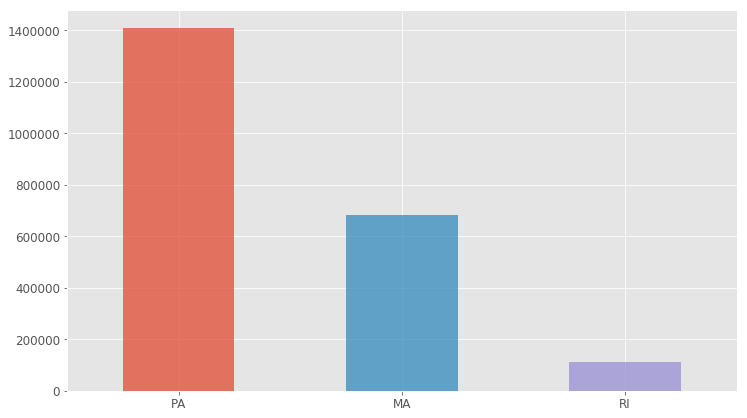

In [12]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,7))
pd_train['prop_state'].value_counts().plot(kind='bar',alpha=0.75, rot=0);

Well, here's our first major problem. The prop_state feature reports correctly the states we are analyzing. But thanks to the heatmap we can see that there are lots of data points with incorrect geo location.

The machine learning model probably won't consider important those geographic features. However, in order to have reliable information we will need to identify those misslabeled datapoints and find a way to fix them. The Google Maps API can be useful here.

## Remove rows with no geographic information
How can we easily identify those misslabeled geographic datapoints? We know there are only three states, so the data should be clustered in three main groups. First, let's remove the previously imputed datapoints. We labeled them as lat_imputed=1 so, we'll filter them and use a joinplot to see the datapoints outside the three clusters MA, PA, RI.

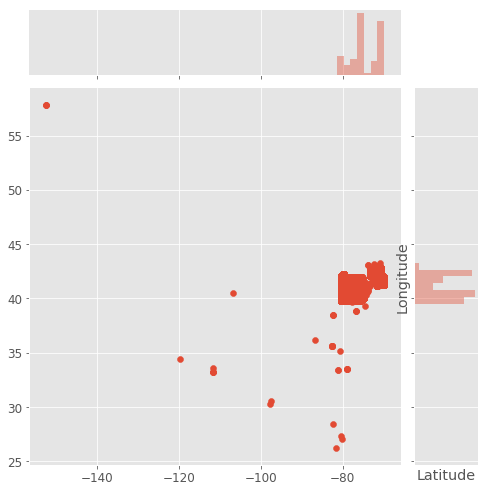

In [13]:
# filter train dataframe
lat_not_null = (pd_train['lat_imputed']==0)
pd_map = pd_train[lat_not_null]

sns.jointplot(x=pd_map['longitude'].values, y=pd_map['latitude'].values, height=7)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show();

Now it's easier to see which are the outliers. We remove those rows outside the clusters and label them so we can put the correct information later.

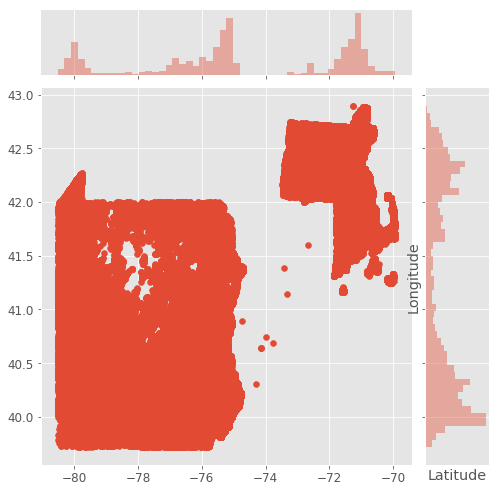

In [14]:
lat_gt_39_lt_43 = (pd_map['latitude']>39.7) & (pd_map['latitude']<42.9)
pd_map = pd_map[lat_gt_39_lt_43]

lng_gt_83 = (pd_map['longitude']>-83)
pd_map = pd_map[lng_gt_83]

sns.jointplot(x=pd_map['longitude'].values, y=pd_map['latitude'].values, height=7)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show();

Now we can calculate the exact number of misslabeled geographic datapoints.

In [15]:
print('Original dataframe size: {}'.format(pd_train.shape[0]))
print('(-) minus Dataframe after eliminating bad [lat,long]: {}'.format(pd_map.shape[0]))
print('(=) Total rows to fix with Google Maps API: {}'.format(pd_train.shape[0] - pd_map.shape[0]))

Original dataframe size: 2203046
(-) minus Dataframe after eliminating bad [lat,long]: 1840365
(=) Total rows to fix with Google Maps API: 362681


## Continue with the Exploratory Data Analysis
We will fix the geographic data later.
Let's continue with the data exploration but before that we can remove some unnecessary features.

A quick look at the percentage of missing values per columns

In [16]:
(pd_train.isnull().sum() / len(pd_train)).sort_values(ascending=False)[:50] #show 50 features, notice that after feature 45 no more nulls are found

irregular_lot_flg           1.000000
prop_house_number_suffix    1.000000
prop_house_number_2         0.999969
prop_direction_right        0.995224
mobile_home_ind             0.993607
timeshare_ind               0.943960
prop_unit_type              0.920928
prop_unit_number            0.920655
construction_quality        0.901723
prop_direction_left         0.876984
garage_type                 0.734235
tax_cd_area                 0.717958
roof_type                   0.696080
roof_cover                  0.614147
air_conditioning            0.566194
construction_type           0.565465
zoning                      0.529965
condition                   0.423251
basement_cd                 0.400208
style                       0.302887
heating_type                0.225925
stories_cd                  0.169818
geocode_latitude            0.164603
geocode_longitude           0.164603
avm_final_value4            0.164603
avm_std_deviation4          0.164603
avm_final_value0            0.143381
a

We'll drop those columns with more than 80% missing values. Also, according to the data dictionary avm_final_value and avm_std_deviation are automated valuation metrics. We don't know how they were calculated. If those features were calculated with house_price included (the target feature) then those calculated features could be considered data leakage. We'll remove them too for our analysis.

In [17]:
pd_train.drop(['irregular_lot_flg','prop_house_number_suffix','prop_house_number_2','prop_direction_right','mobile_home_ind'
            ,'timeshare_ind','prop_unit_type','prop_unit_number','construction_quality','prop_direction_left'
            ,'fips_cd','IsTraining','prop_house_number','prop_street_name','geocode_latitude','geocode_longitude','transaction_date'
            ,'avm_final_value0','avm_std_deviation0','avm_final_value1','avm_std_deviation1','avm_final_value2','avm_std_deviation2'
            ,'avm_final_value3','avm_std_deviation3','avm_final_value4','avm_std_deviation4'
           ], axis=1, inplace=True)

## Let's take a look at the house price distribution

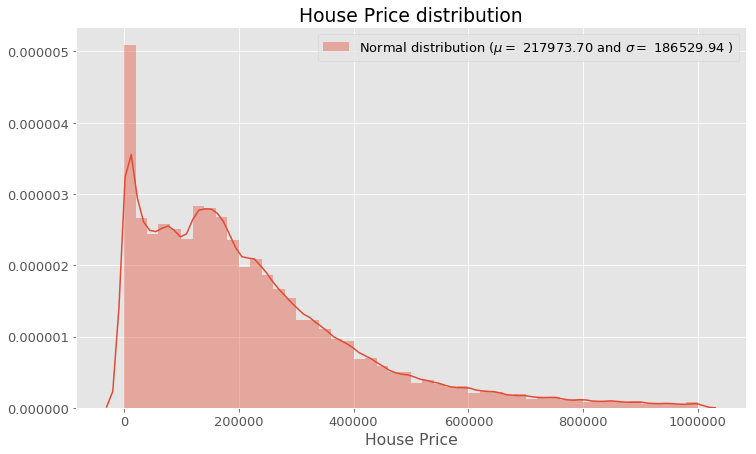

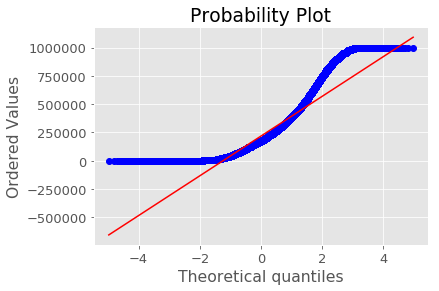

In [18]:
from scipy import stats
from scipy.stats import norm, skew

# filter outliers before plotting
no_outliers = pd_train[pd_train['sale_amt'] <= 1000000]

plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(12, 7))
sns.distplot(no_outliers['sale_amt'])
(mu, sigma) = norm.fit(no_outliers['sale_amt'])
plt.legend(['Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.xlabel('House Price')
plt.title('House Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(no_outliers['sale_amt'], plot=plt)
plt.show();

Data is highly skewed. We know that a log transformation is useful for this type of cases. Or, is it?

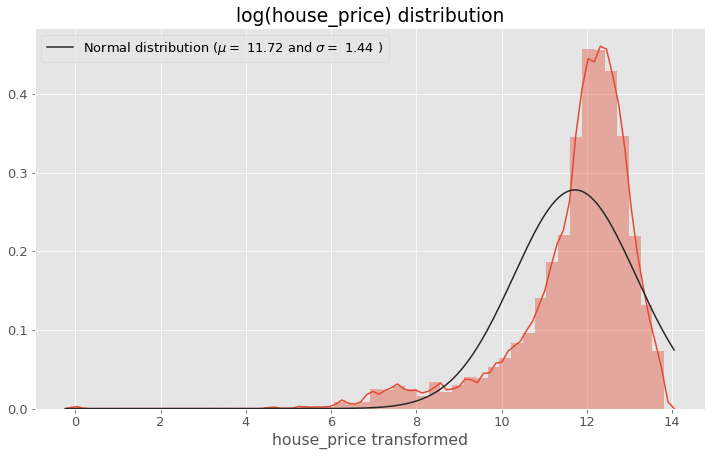

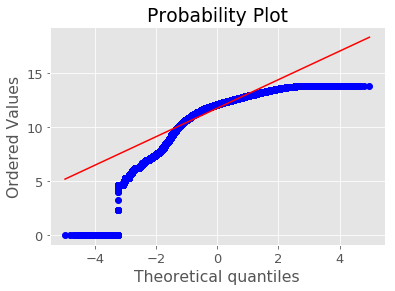

In [19]:
# distribution with log transformation
fig = plt.figure(figsize=(12, 7))
sns.distplot(np.log(no_outliers['sale_amt']), fit=norm);
(mu, sigma) = norm.fit(np.log(no_outliers['sale_amt']))
plt.legend(['Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.xlabel('house_price transformed')
plt.title('log(house_price) distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(np.log(no_outliers['sale_amt']), plot=plt)
plt.show();

Looking at the QQ-plot, the log transformation doesn't fully normalize the data. Another common transformation is done by using Log(home_price + 1). 

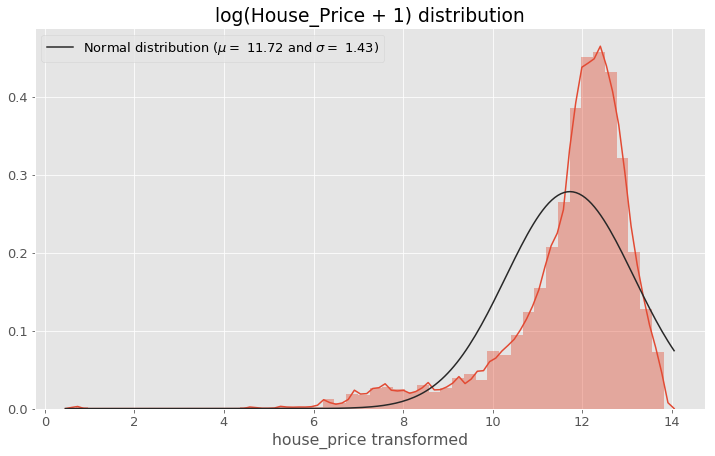

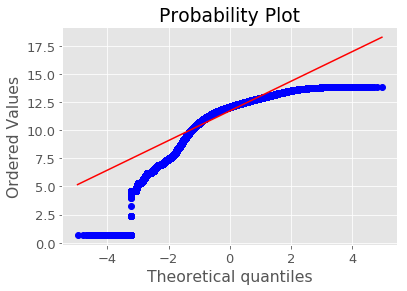

In [20]:
# distribution with log+1 transformation
fig = plt.figure(figsize=(12, 7))
sns.distplot(np.log1p(no_outliers['sale_amt']), fit=norm);
(mu, sigma) = norm.fit(np.log1p(no_outliers['sale_amt']))
plt.legend(['Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.xlabel('house_price transformed')
plt.title('log(House_Price + 1) distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(no_outliers['sale_amt']), plot=plt)
plt.show();

It only changed the standard deviation, compared to the previous Log transformation.

We have to dig deeper to understand what's going on with this feature and see how we can better normalize it. Let's take a look at how the data is represented by state. 

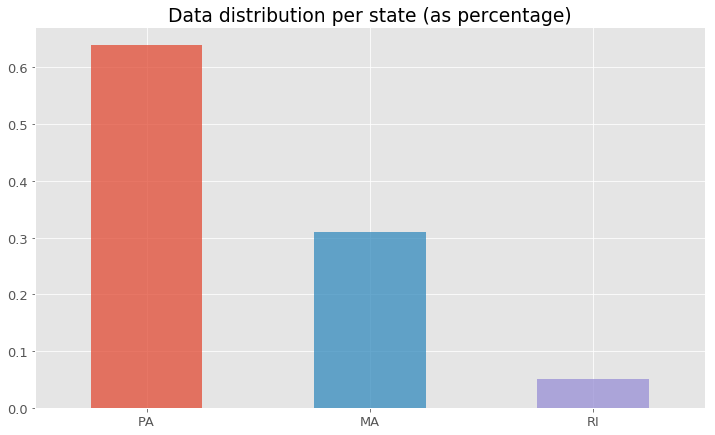

In [21]:
plt.subplots(figsize=(12,7))
plt.title('Data distribution per state (as percentage)')
(pd_train['prop_state'].value_counts() / len(pd_train)).plot(kind='bar', alpha=0.75, rot=0);

Data totally unbalanced. Over 60% of home sales contained on the data are from Pensylvannia.

Instead of looking at the house counts, we can better focus on the house_price averages with the help of box plots.

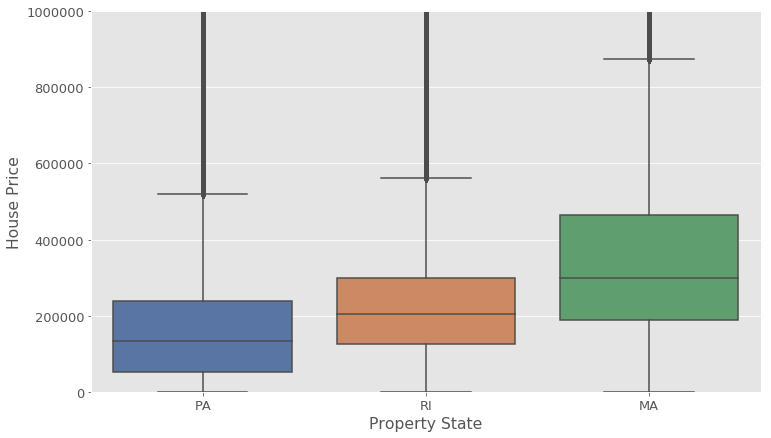

In [22]:
plt.subplots(figsize=(12,7))
sns.boxplot(x='prop_state', y='sale_amt', data=pd_train, palette='deep')
plt.ylim(0, 1000000)
plt.xlabel('Property State')
plt.ylabel('House Price');

We see that on average the houses in Massachusetts are more expensive.

Now we'll take a look at the house sales over the last two years. We take year+month to group all the houses sold each year and month respectively.

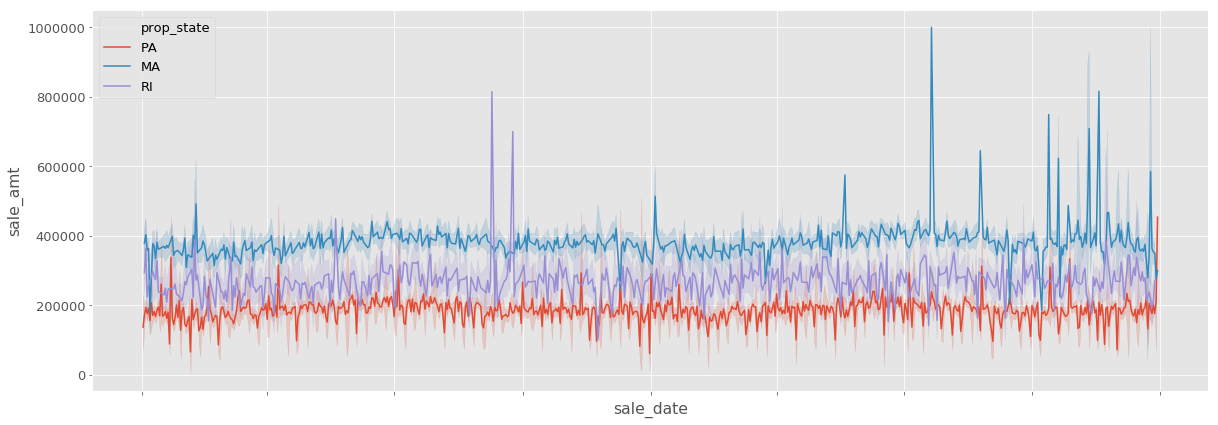

In [23]:
import time
from datetime import date

# concatenate year-month for easy grouping
pd_train['sale_yr_month'] = pd_train['sale_date'].apply(lambda x: str(x.year) + '-' + str(x.strftime('%m')))

# filter data to show only the last 2 years of home sales
from datetime import datetime
date_lo = datetime(2017,1,1)
date_hi = datetime(2018,12,31)

no_outliers = pd_train[pd_train['sale_amt'] <= 1000000]
# Houses can appear multiple times if sold more than once over the years. Remove duplicates keeping only the most recent transaction
no_outlier_or_duplicate = no_outliers.sort_values('sale_date')
no_outlier_or_duplicate = no_outlier_or_duplicate.drop_duplicates(['apn'], keep='last')

two_year_filter = no_outlier_or_duplicate[(no_outlier_or_duplicate['sale_date'] > date_lo.date())
                                       & (no_outlier_or_duplicate['sale_date'] < date_hi.date())]

plt.subplots(figsize=(20,7))
loc, labels = plt.xticks()
line_plot = sns.lineplot(x='sale_date', y='sale_amt', hue='prop_state', data=two_year_filter);
line_plot.set_xticklabels(labels, rotation=45);

Using our recently created feature year-month, we can appreciate better the seasonality of the data.

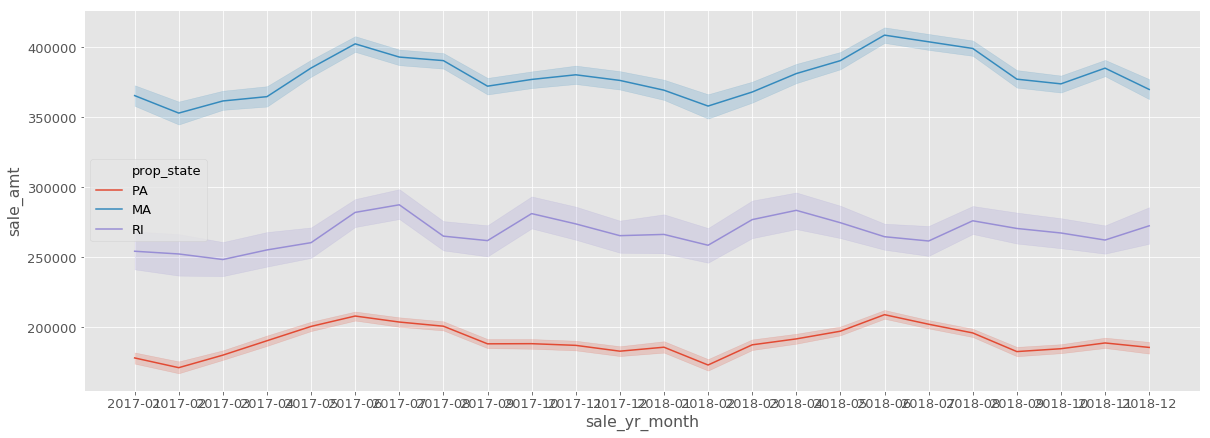

In [24]:
plt.subplots(figsize=(20, 7))
line_plot = sns.lineplot(x='sale_yr_month', y='sale_amt', hue='prop_state', data=two_year_filter)

Will the data show what happened during the 2008 recession?

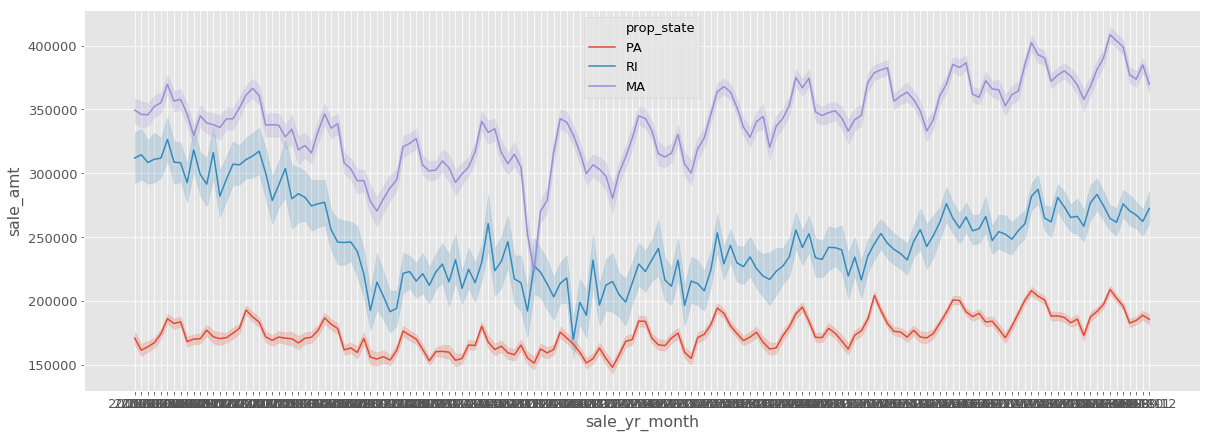

In [25]:
# filter data to show the whole period from 2006 to 2018
date_lo = datetime(2006,1,1)
date_hi = datetime(2018,12,31)

filter_13_years = no_outlier_or_duplicate[(no_outlier_or_duplicate['sale_date'] > date_lo.date()) 
                                          & (no_outlier_or_duplicate['sale_date'] < date_hi.date())]

plt.subplots(figsize=(20,7))
line_plot = sns.lineplot(x='sale_yr_month', y='sale_amt', hue='prop_state', data=filter_13_years)

It looks like Rhode Island was the most affected state during the recession. Houses lost roughly 30% of their value after 2008 and haven't recovered after 10 years.

# Feature Engineering
In this dataset we have two main feature types:
1. Categorical
2. Numerical

We will treat them separetely, for categorical features we'll use one-hot-encoding. For the remaining numerical features we'll use a MinMaxScaler transformation. 

Pandas_profiling turned out to be a great tool to help us discard right away features with either high cardinality or high correlation with other variables.

In [26]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import pandas_profiling

profile = pandas_profiling.ProfileReport(no_outlier_or_duplicate)
profile.to_file(outputfile="pd_profiling_output.html")

A good way to summarize all the information contained in the profiling report it's with a correlation heatmap. This is done with all the numerical features.

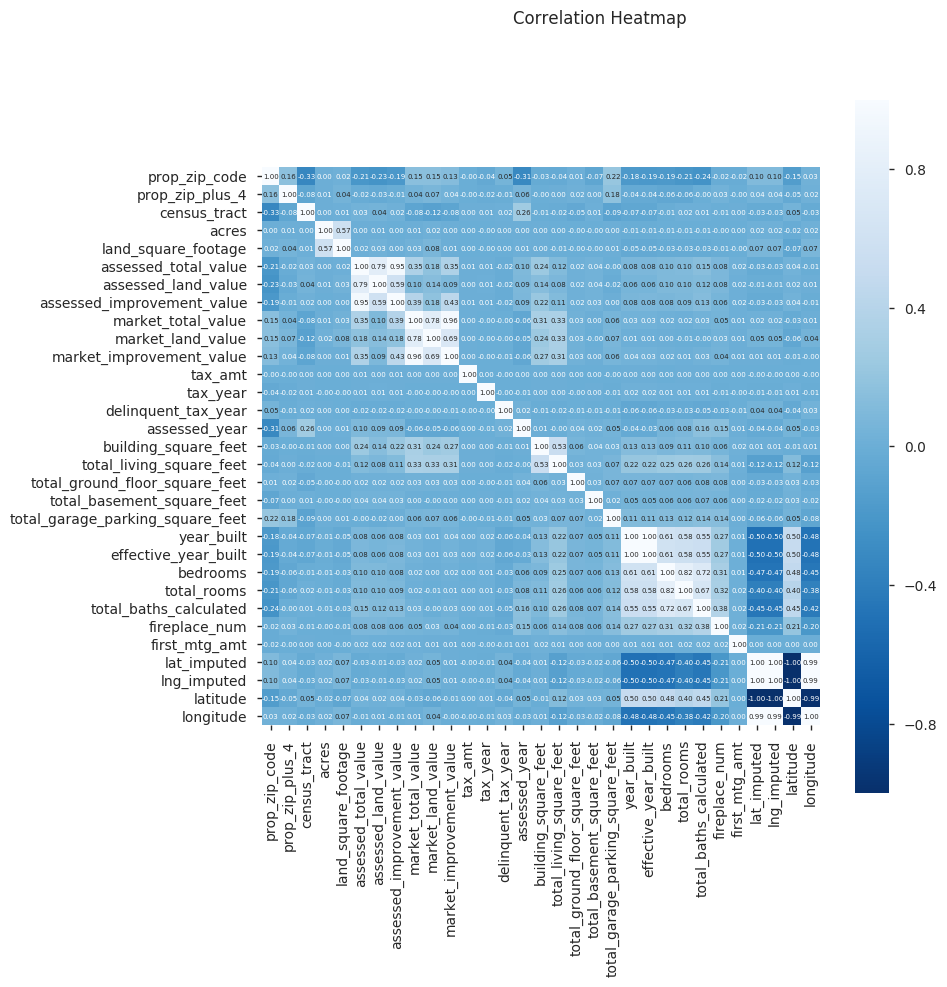

In [27]:
pd.set_option('precision', 2)
plt.subplots(figsize=(9, 9))
sns.heatmap(no_outlier_or_duplicate.drop(['sale_amt'], axis=1).corr(), square=True, cmap='Blues_r', annot=True, annot_kws={'size': 5}, fmt='.2f')
plt.suptitle('Correlation Heatmap')
plt.show();

We know correlation across the diagonal is 1 because it's when the feature is being correlated with itself. We pay attention to the clear spots near the diagonal and we will find the other features highly correlated with neighboring features. This is a sign of multicollinearity, which we will try to avoid.

Another way of visualizing the correlation with sale_amount is with a bar plot.

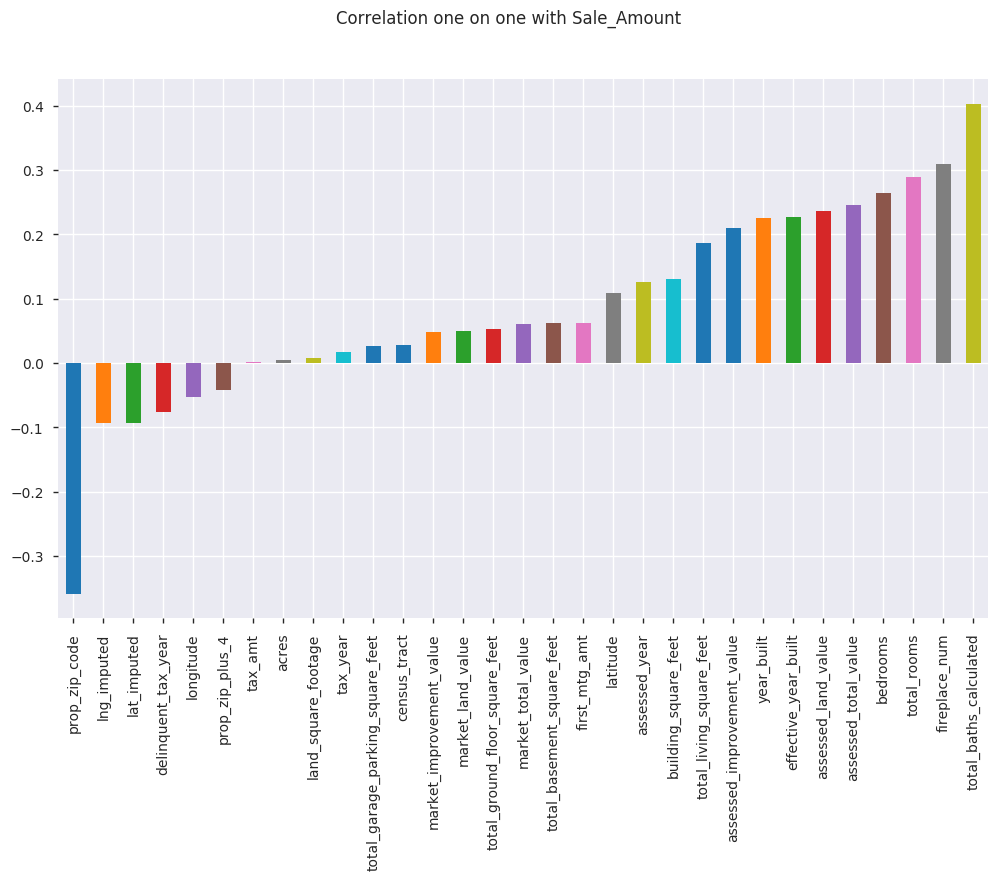

In [28]:
sale_price_corr = no_outlier_or_duplicate.corr()['sale_amt'].sort_values(ascending=True)
plt.subplots(figsize=(12, 7))
sale_price_corr.drop('sale_amt').plot.bar()
plt.suptitle('Correlation one on one with Sale_Amount')
plt.show();

The plot shows correlation of numerical features with the target feature: sale_amt. We can see all the spectrum, starting on negative correlation with prop_zip_code; near zero correlation with tax_amt; and the maximum positive correlation with total_baths_calculated.

Correlation doesn't mean that those features at the right of the previous plot are the most important for a machine learning algorithm. We will find those more important features with the help of ElasticNet.

In [29]:
from IPython.core.display import display, HTML
display(HTML("""<p>Click<a href="pd_profiling_output.html" target="_blank"> here </a>for the full profiling report.</p>"""))

### First approach: Log transformation
We will jump right into log transformation for all the numerical features.

In [30]:
# remove all outliers in pricing features (from main pandas dataframe)
no_outliers = pd_train.query('''assessed_total_value<=1000000 & assessed_land_value<=1000000 & assessed_improvement_value<=1000000 & market_total_value<=1000000 & market_land_value<=1000000 & market_improvement_value<=1000000 & tax_amt<=1000000 & first_mtg_amt<=1000000 & sale_amt<=1000000''')

# also, a house can be sold more than once over the years. Remove duplicates keeping only the most recent transaction
no_outlier_or_duplicate = no_outliers.sort_values('sale_date')
no_outlier_or_duplicate = no_outlier_or_duplicate.drop_duplicates(['apn'], keep='last')

num_features_mask = no_outlier_or_duplicate.dtypes[no_outlier_or_duplicate.dtypes != "object"].index

# drop from numeric features those pertaining dates, or categories such as zip_code
num_features_mask = num_features_mask.drop(['prop_zip_code','prop_zip_plus_4','census_tract','assessed_improvement_value'
                                            ,'market_improvement_value','tax_year','delinquent_tax_year','assessed_year'
                                            ,'year_built','effective_year_built','lat_imputed','latitude','lng_imputed','longitude'])

# create an index for features with values skewed more than 75%
skewed_features = no_outlier_or_duplicate[num_features_mask].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features_idx = skewed_features.index

# use skewed index to apply log transformation
no_outlier_or_duplicate[skewed_features_idx] = np.log1p(no_outlier_or_duplicate[skewed_features_idx])

# remove null values for mortgage_amount
no_outlier_or_duplicate.dropna(subset=['first_mtg_amt'], inplace=True)

print('Total features', len(no_outlier_or_duplicate.columns))
no_outlier_or_duplicate[:5]

Total features 52


,apn,prop_suffix,prop_city,prop_state,prop_zip_code,prop_zip_plus_4,dwelling_type,zoning,census_tract,acres,land_square_footage,assessed_total_value,assessed_land_value,assessed_improvement_value,market_total_value,market_land_value,market_improvement_value,tax_amt,tax_year,delinquent_tax_year,assessed_year,tax_cd_area,building_square_feet,total_living_square_feet,total_ground_floor_square_feet,total_basement_square_feet,total_garage_parking_square_feet,year_built,effective_year_built,bedrooms,total_rooms,total_baths_calculated,air_conditioning,basement_cd,condition,construction_type,fireplace_num,garage_type,heating_type,roof_cover,roof_type,stories_cd,style,first_mtg_amt,distressed_sale_flg,sale_amt,sale_date,lat_imputed,lng_imputed,latitude,longitude,sale_yr_month
2410,22 G02-0016A--000,RD,GARDNERS,PA,17324.0,9618.0,Mobile home,None,30200.0,1.16,11.47,12.05,11.11,103400.0,12.05,11.11,103400.0,7.88,2018,0,2018,BERMUDIAN,7.36,7.36,0.0,0.0,6.59,2003,2003,3,5,2,Central,None,None,None,0.0,Attached Garage,Forced air unit,None,None,100,33,0.0,None,4.62,1960-10-14,0,0,40.04,-77.18,1960-10
416327,N09-000-00035 01,HWY,WEST DECATUR,PA,16878.0,8835.0,Single Family Residential,None,331000.0,0.85,10.97,9.07,7.48,6950.0,10.46,8.87,27800.0,7.12,2018,0,2018,None,0.00,0.00,0.0,0.0,0.00,0,0,0,0,0,None,None,None,None,0.0,None,None,None,None,None,None,0.0,None,6.91,1961-04-01,1,1,0.00,0.00,1961-04
1353329,50-000-KD-0016.L0-00000,RD,DOVER,PA,17315.0,2838.0,Residential-Vacant Land,None,20320.0,0.91,11.07,8.70,8.70,0.0,8.70,8.70,0.0,5.14,2018,0,2018,TAX 050,0.00,0.00,0.0,0.0,0.00,0,0,0,0,0,None,None,None,None,0.0,None,None,None,None,None,None,0.0,Y,5.00,1962-01-23,1,1,0.00,0.00,1962-01
351250,"25-009-,161-,0000-",AVE,BOALSBURG,PA,16827.0,NaN,Vacant Land (General),None,NaN,0.29,9.60,9.48,9.48,0.0,10.18,10.18,0.0,6.39,2018,0,2018,None,0.00,0.00,0.0,0.0,0.00,0,0,0,0,0,None,None,None,None,0.0,None,None,None,None,None,None,0.0,Y,6.69,1962-10-04,1,1,0.00,0.00,1962-10
618747,01-162-0129-GA,DR,CLARINGTON,PA,15828.0,2326.0,Single Family Residential,None,950200.0,0.37,9.88,8.31,7.15,2800.0,8.31,7.15,2800.0,5.23,2018,0,2018,None,6.07,6.07,0.0,0.0,0.00,1962,1962,0,0,0,None,None,None,None,0.0,None,None,None,None,100,None,0.0,Y,7.20,1964-07-25,0,0,41.32,-79.15,1964-07


 Ignoring for now the categorical features. In this way we can create a simple model fast and find the most important features with ElasticNet.

In [31]:
from sklearn.model_selection import train_test_split

X, y = no_outlier_or_duplicate[['acres', 'land_square_footage', 'assessed_total_value'
                                ,'assessed_land_value', 'market_total_value', 'market_land_value'
                                ,'tax_amt', 'building_square_feet', 'total_living_square_feet'
                                ,'total_ground_floor_square_feet', 'total_basement_square_feet'
                                ,'total_garage_parking_square_feet', 'bedrooms', 'total_rooms'
                                ,'total_baths_calculated', 'fireplace_num','first_mtg_amt']], no_outlier_or_duplicate['sale_amt'].values

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [32]:
from sklearn.linear_model import ElasticNetCV

# create elastic_net model and fit the training data
elastic_net_CVmodel = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=100, fit_intercept=True
                                   ,normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5 
                                   ,copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=7)

elastic_net_CVmodel.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=2000,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=7, selection='cyclic', tol=0.0001,
       verbose=0)

ElasticNet is a quick way to find out the most important features which we can use for the regression model next.

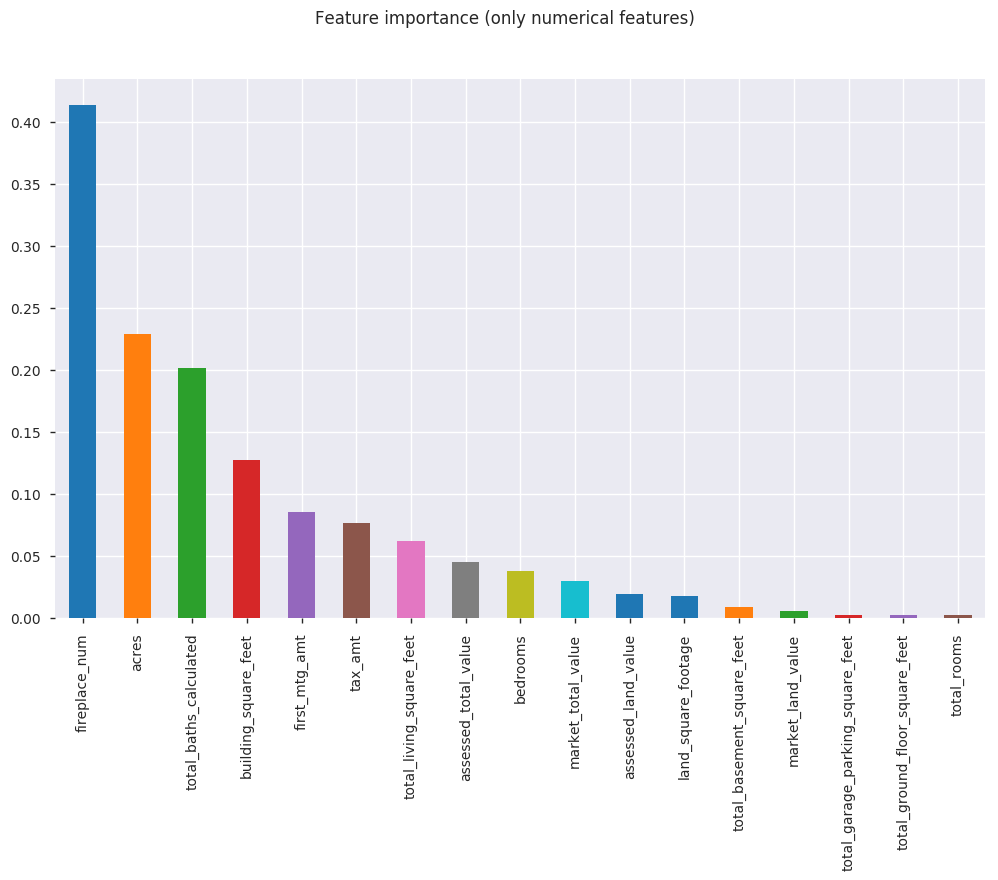

In [33]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(elastic_net_CVmodel.coef_))

plt.subplots(figsize=(12,7))
plt.suptitle('Feature importance (only numerical features)')
feature_importance.sort_values(ascending=False).plot(kind='bar');

Next, our first model. Let's try a Random Forest Regressor.

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# create and fit the training data
rfr_log = RandomForestRegressor(max_depth=2, random_state=7, n_estimators=100)

rfr_log.fit(X_train, y_train)

# Make predictions using the train and test set
y_train_pred_rfr = rfr_log.predict(X_train)
y_test_pred_rfr = rfr_log.predict(X_test)

# evaluate the model
print('\nTrain r2 score: {:.6f}'.format(r2_score(y_train_pred_rfr, y_train)))
print('Test r2 score: {:.6f}'.format(r2_score(y_test_pred_rfr, y_test)))
train_mse = mean_squared_error(y_train_pred_rfr, y_train)
test_mse = mean_squared_error(y_test_pred_rfr, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: {:.4f}'.format(train_rmse))
print('Test RMSE: {:.4f}'.format(test_rmse))


Train r2 score: -0.277262
Test r2 score: -0.262076
Train RMSE: 0.9666
Test RMSE: 0.9623


That is a really bad model.

Is it an algorithm problem? Let's try Gradient Boosting

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)

y_train_pred_gb = gbr_model.predict(X_train)
y_test_pred_gb = gbr_model.predict(X_test)

print('\nTrain r2 score: {:.6f}'.format(r2_score(y_train_pred_gb, y_train)))
print('Test r2 score: {:.6f}'.format(r2_score(y_test_pred_gb, y_test)))
train_mse = mean_squared_error(y_train_pred_gb, y_train)
test_mse = mean_squared_error(y_test_pred_gb, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: {:.4f}'.format(train_rmse))
print('Test RMSE: {:.4f}'.format(test_rmse))


Train r2 score: 0.393508
Test r2 score: 0.395449
Train RMSE: 0.7860
Test RMSE: 0.7846


Well, this is a better model but still a lot of room for improvement. Let's incorporate the categorical features and find out a better way to transform the numeric ones.

## A better approach to feature engineering

### 1. Categorical features 

For all categorical features, apply one-hot-encoding.

When dealing with categorical features it is important to check whether the features we consider as categorical can be in fact treated as categories. If there's high cardinality in the column (too many different values) then the one-hot-encoding won't be of any use because we would be creating just too many new features.

A good book to read about this topic is: "Witten, I. H., & Frank, E. (2011). Data mining : Practical machine learning tools and techniques. Third edition."

As an example of high cardinality let's take a look at prop_suffix. This feature represents an abbreviation of the street, road, avenue, etc. on the address of each house.

In [36]:
print(no_outlier_or_duplicate['prop_suffix'].value_counts()[:10])
print('Total unique groups for prop_suffix: ', len(no_outlier_or_duplicate['prop_suffix'].value_counts()))

ST      483553
RD      300152
AVE     192617
DR      186072
LN       82812
CT       33454
WAY      24793
CIR      24484
BLVD     11105
PL       10474
Name: prop_suffix, dtype: int64
Total unique groups for prop_suffix:  138


138 possible categories!

As an opposite example let's take a look at "condition", which tells us the general condition of the house or property.

In [37]:
no_outlier_or_duplicate['condition'].value_counts()

Average      585978
Good         139903
Fair          50976
Excellent     18518
Poor           9735
Unsound        3060
Name: condition, dtype: int64

Only 6 possible categories for the feature 'condition'. Clearly this feature is a good candidate to transform with one-hot-encoding.

With the profiling report we learned that there are more outliers. They exist not only on the sale_price, but on each of the features with dollar amounts. Remove them.

In [38]:
# remove all outliers in pricing features (from main pandas dataframe)
no_outliers = pd_train.query('''assessed_total_value<=1000000 & assessed_land_value<=1000000 & assessed_improvement_value<=1000000 & market_total_value<=1000000 & market_land_value<=1000000 & market_improvement_value<=1000000 & tax_amt<=1000000 & first_mtg_amt<=1000000 & sale_amt<=1000000''')

# also, a house can be sold more than once over the years. Remove duplicates keeping only the most recent transaction
no_outlier_or_duplicate = no_outliers.sort_values('sale_date')
no_outlier_or_duplicate = no_outlier_or_duplicate.drop_duplicates(['apn'], keep='last')

no_outlr_or_dup = no_outlier_or_duplicate.copy()
no_outlr_or_dup[:5]

,apn,prop_suffix,prop_city,prop_state,prop_zip_code,prop_zip_plus_4,dwelling_type,zoning,census_tract,acres,land_square_footage,assessed_total_value,assessed_land_value,assessed_improvement_value,market_total_value,market_land_value,market_improvement_value,tax_amt,tax_year,delinquent_tax_year,assessed_year,tax_cd_area,building_square_feet,total_living_square_feet,total_ground_floor_square_feet,total_basement_square_feet,total_garage_parking_square_feet,year_built,effective_year_built,bedrooms,total_rooms,total_baths_calculated,air_conditioning,basement_cd,condition,construction_type,fireplace_num,garage_type,heating_type,roof_cover,roof_type,stories_cd,style,first_mtg_amt,distressed_sale_flg,sale_amt,sale_date,lat_imputed,lng_imputed,latitude,longitude,sale_yr_month
2410,22 G02-0016A--000,RD,GARDNERS,PA,17324.0,9618.0,Mobile home,None,30200.0,2.20,95832,170300.0,66900.0,103400.0,170300.0,66900.0,103400.0,2637.49,2018,0,2018,BERMUDIAN,1568,1568,0,0,728,2003,2003,3,5,2,Central,None,None,None,0,Attached Garage,Forced air unit,None,None,100,33,0.0,None,100.0,1960-10-14,0,0,40.04,-77.18,1960-10
416327,N09-000-00035 01,HWY,WEST DECATUR,PA,16878.0,8835.0,Single Family Residential,None,331000.0,1.33,57934,8725.0,1775.0,6950.0,34900.0,7100.0,27800.0,1233.45,2018,0,2018,None,0,0,0,0,0,0,0,0,0,0,None,None,None,None,0,None,None,None,None,None,None,0.0,None,1000.0,1961-04-01,1,1,0.00,0.00,1961-04
1353329,50-000-KD-0016.L0-00000,RD,DOVER,PA,17315.0,2838.0,Residential-Vacant Land,None,20320.0,1.48,64469,6000.0,6000.0,0.0,6000.0,6000.0,0.0,169.10,2018,0,2018,TAX 050,0,0,0,0,0,0,0,0,0,0,None,None,None,None,0,None,None,None,None,None,None,0.0,Y,148.0,1962-01-23,1,1,0.00,0.00,1962-01
351250,"25-009-,161-,0000-",AVE,BOALSBURG,PA,16827.0,NaN,Vacant Land (General),None,NaN,0.34,14810,13145.0,13145.0,0.0,26290.0,26290.0,0.0,594.23,2018,0,2018,None,0,0,0,0,0,0,0,0,0,0,None,None,None,None,0,None,None,None,None,None,None,0.0,Y,800.0,1962-10-04,1,1,0.00,0.00,1962-10
618747,01-162-0129-GA,DR,CLARINGTON,PA,15828.0,2326.0,Single Family Residential,None,950200.0,0.45,19602,4070.0,1270.0,2800.0,4070.0,1270.0,2800.0,185.88,2018,0,2018,None,432,432,0,0,0,1962,1962,0,0,0,None,None,None,None,0,None,None,None,None,100,None,0.0,Y,1340.0,1964-07-25,0,0,41.32,-79.15,1964-07


Discard all the features either with high cardinality or high correlation with other variables.

In [39]:
no_outlr_or_dup.drop(['apn', 'prop_suffix', 'prop_city', 'prop_zip_code', 'prop_zip_plus_4', 'zoning', 'delinquent_tax_year', 'assessed_improvement_value'
                      ,'market_improvement_value', 'assessed_year', 'effective_year_built', 'tax_cd_area', 'air_conditioning', 'basement_cd'
                      , 'construction_type', 'census_tract', 'tax_year', 'garage_type', 'roof_cover', 'roof_type', 'style', 'sale_date'
                      , 'lat_imputed', 'lng_imputed', 'latitude', 'longitude', 'sale_yr_month'], axis=1, inplace=True)
no_outlr_or_dup[:5]

,prop_state,dwelling_type,acres,land_square_footage,assessed_total_value,assessed_land_value,market_total_value,market_land_value,tax_amt,building_square_feet,total_living_square_feet,total_ground_floor_square_feet,total_basement_square_feet,total_garage_parking_square_feet,year_built,bedrooms,total_rooms,total_baths_calculated,condition,fireplace_num,heating_type,stories_cd,first_mtg_amt,distressed_sale_flg,sale_amt
2410,PA,Mobile home,2.20,95832,170300.0,66900.0,170300.0,66900.0,2637.49,1568,1568,0,0,728,2003,3,5,2,None,0,Forced air unit,100,0.0,None,100.0
416327,PA,Single Family Residential,1.33,57934,8725.0,1775.0,34900.0,7100.0,1233.45,0,0,0,0,0,0,0,0,0,None,0,None,None,0.0,None,1000.0
1353329,PA,Residential-Vacant Land,1.48,64469,6000.0,6000.0,6000.0,6000.0,169.10,0,0,0,0,0,0,0,0,0,None,0,None,None,0.0,Y,148.0
351250,PA,Vacant Land (General),0.34,14810,13145.0,13145.0,26290.0,26290.0,594.23,0,0,0,0,0,0,0,0,0,None,0,None,None,0.0,Y,800.0
618747,PA,Single Family Residential,0.45,19602,4070.0,1270.0,4070.0,1270.0,185.88,432,432,0,0,0,1962,0,0,0,None,0,None,100,0.0,Y,1340.0


Drop the row with NaN or None values before one-hot-encoding.

In [40]:
no_outlr_or_dup.dropna(subset=['dwelling_type', 'year_built' ,'condition','heating_type', 'stories_cd', 'distressed_sale_flg'], inplace=True)

Ready to call OneHotEncoder. In sklearn it is located in the preprocessing module. Super convenient because you encode the categorical variables and at the end you have the option to decide what to do with the remaining variables. In our case, we chose use the MinMaxScaler() so in one step we are transforming the categorical and the numerical features into something the machine learning algorithm can use.

In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

column_transf = ColumnTransformer(
    [('prop_state_encoder', OneHotEncoder(dtype='int'), ['prop_state'])
    ,('dwelling_type_encoder', OneHotEncoder(dtype='int'), ['dwelling_type'])
    ,('year_built_encoder', OneHotEncoder(dtype='int'), ['year_built'])
    ,('condition_encoder', OneHotEncoder(dtype='int'), ['condition'])
    ,('heating_type_encoder', OneHotEncoder(dtype='int'), ['heating_type'])
    ,('stories_cd_encoder', OneHotEncoder(dtype='int'), ['stories_cd'])
    ,('distressed_sale_flg_encoder', OneHotEncoder(dtype='int'), ['distressed_sale_flg'])]
    , remainder=MinMaxScaler())

column_transf.fit(no_outlr_or_dup)

final_df = column_transf.transform(no_outlr_or_dup).toarray()

The resulting dataframe has 439 columns, and it's ready to be used in our model.

In [42]:
final_df.shape

(692843, 439)

Note on selected scaler: MinMaxScaler was selected after performing tests on each of the available scalers for the ColumnTransformer.

Here are the results after each test to the four available scaler methods.

### MinMaxScaler
    
Train r2 score: 0.6747472665087146           Train RMSE: 0.0889

Test r2 score : 0.757005690595891            Test RMSE: 0.0900

### StandardScaler

Train r2 score: 0.6747472665087157           Train RMSE: 0.4875

Test r2 score : 0.7570056905958891           Test RMSE: 0.4933

### RobustScaler

Train r2 score: 0.6747472665087137           Train RMSE: 0.4136

Test r2 score : 0.7570056905958891           Test RMSE: 0.4185

### Normalizer

Train r2 score: -3.3139329404736815          Train RMSE: 0.1044

Test r2 score : 0.36247768184181806          Test RMSE: 0.1043

### Model creation

Now we have our final dataframe with no outliers, no nulls and with all the features either scaled or one-hot-encoded. We are ready to try our first  model with a dataset containing numerical and categorical-encoded features. First split into training and testing sets with a 80/20 ratio.

In [43]:
from sklearn.model_selection import train_test_split

X, y = final_df[:, :438], final_df[:, 438:439]
y = y[:, -1]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 7)

We start with a simple linear regression and then move to more complex models

In [44]:
from sklearn import linear_model

# Create linear regression model and fit the training set
lm_r = linear_model.LinearRegression()
lm_r.fit(X_train, y_train)

# Make predictions using the train and test set
y_train_pred_lm = lm_r.predict(X_train)
y_test_pred_lm = lm_r.predict(X_test)

# The coefficients
print('Coefficients: \n', lm_r.coef_[:10])  # take a look at the first 10 coeficcients

# evaluate the model
print('\nTrain r2 score: {:.6f}'.format(r2_score(y_train_pred_lm, y_train)))
print('Test r2 score: {:.6f}'.format(r2_score(y_test_pred_lm, y_test)))
train_mse_lm = mean_squared_error(y_train_pred_lm, y_train)
test_mse_lm = mean_squared_error(y_test_pred_lm, y_test)
train_rmse_lm = np.sqrt(train_mse_lm)
test_rmse_lm = np.sqrt(test_mse_lm)
print('Train RMSE: {:.4f}'.format(train_rmse_lm))
print('Test RMSE: {:.4f}'.format(test_rmse_lm))

Coefficients: 
 [ 1.64947837e+10  1.64947837e+10  1.64947837e+10 -3.58264352e+09
 -3.58264352e+09 -3.58264352e+09 -3.58264352e+09 -3.58264352e+09
 -3.58264352e+09 -3.58264352e+09]

Train r2 score: 0.738743
Test r2 score: -0.000005
Train RMSE: 0.0857
Test RMSE: 1809394191.8855


Looking at the r2 scores, we see that the model does quite well on the training set: 0.73. But it fails on the test set: negative value?

We could change some parameters to try fixing the performance, but for the moment we will move on and create a different model to compare scores.
Let's try Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor

# create the model and fit the training set
rfr_model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
rfr_model.fit(X, y)

# Make predictions using the train and test set
#print(rfr_model.feature_importances_)
y_train_pred_rf = rfr_model.predict(X_train)
y_test_pred_rf = rfr_model.predict(X_test)

# evaluate the model
print('Train r2 score: {:.6f}'.format(r2_score(y_train_pred_rf, y_train)))
print('Test r2 score: {:.6f}'.format(r2_score(y_test_pred_rf, y_test)))
train_mse_rf = mean_squared_error(y_train_pred_rf, y_train)
test_mse_rf = mean_squared_error(y_test_pred_rf, y_test)
train_rmse_rf = np.sqrt(train_mse_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
print('Train RMSE: {:.4f}'.format(train_rmse_rf))
print('Test RMSE: {:.4f}'.format(test_rmse_rf))

Train r2 score: 0.475766
Test r2 score: 0.474408
Train RMSE: 0.1100
Test RMSE: 0.1102


Random forest clearly does better over linear regression with the test set. However, our model is far from ideal.

The parameters for the RFRegressor were not changed from the default values. Again, we could do some parameter tuning to improve the model but for now we're just going to try a more robust algorithm that has been gaining a lot of popularity in recent years: XGBoost.

In [ ]:
from xgboost import XGBRegressor
xgbr_model = XGBRegressor()
xgbr_model.fit(X_train, y_train)

y_train_pred_xg = xgbr_model.predict(X_train)
y_test_pred_xg = xgbr_model.predict(X_test)

# evaluate the model
print('Train r2 score: {:.6f}'.format(r2_score(y_train_pred_xg, y_train)))
print('Test r2 score: {:.6f}'.format(r2_score(y_test_pred_xg, y_test)))
train_mse = mean_squared_error(y_train_pred_xg, y_train)
test_mse = mean_squared_error(y_test_pred_xg, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: {:.4f}'.format(train_rmse))
print('Test RMSE: {:.4f}'.format(test_rmse))

Train r2 score: 0.802498
Test r2 score: 0.797524
Train RMSE: 0.0756
Test RMSE: 0.0765


So far this is the best model. Now it's time to spend a little more time on parameter optimization.

In [ ]:
xgbr_model_2 = XGBRegressor(n_estimators=1000)
xgbr_model_2.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

y_train_pred_xg_2 = xgbr_model_2.predict(X_train)
y_test_pred_xg_2 = xgbr_model_2.predict(X_test)

# evaluate the model
print('Train r2 score: {:.4f}'.format(r2_score(y_train_pred_xg_2, y_train)))
print('Test r2 score: {:.4f}'.format(r2_score(y_test_pred_xg_2, y_test)))
train_mse_2 = mean_squared_error(y_train_pred_xg_2, y_train)
test_mse_2 = mean_squared_error(y_test_pred_xg_2, y_test)
train_rmse_2 = np.sqrt(train_mse_2)
test_rmse_2 = np.sqrt(test_mse_2)
print('Train RMSE: {:.4f}'.format(train_rmse_2))
print('Test RMSE: {:.4f}'.format(test_rmse_2))

[0]	validation_0-rmse:0.271672
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.24798
[2]	validation_0-rmse:0.226889
[3]	validation_0-rmse:0.208167
[4]	validation_0-rmse:0.191548
[5]	validation_0-rmse:0.176872
[6]	validation_0-rmse:0.163805
[7]	validation_0-rmse:0.152337
[8]	validation_0-rmse:0.142398
[9]	validation_0-rmse:0.133513
[10]	validation_0-rmse:0.125793
[11]	validation_0-rmse:0.119146
[12]	validation_0-rmse:0.113441
[13]	validation_0-rmse:0.108499
[14]	validation_0-rmse:0.104219
[15]	validation_0-rmse:0.100584
[16]	validation_0-rmse:0.097482
[17]	validation_0-rmse:0.094815
[18]	validation_0-rmse:0.092589
[19]	validation_0-rmse:0.090646
[20]	validation_0-rmse:0.089001
[21]	validation_0-rmse:0.08762
[22]	validation_0-rmse:0.086437
[23]	validation_0-rmse:0.085422
[24]	validation_0-rmse:0.084599
[25]	validation_0-rmse:0.083821
[26]	validation_0-rmse:0.083234
[27]	validation_0-rmse:0.082653
[28]	validation_0-rmse:0.082183
[29]	validation_0-rm

That looks even better and the only change we did was to increase the estimators. Let's try another tweak to the model.

In [ ]:
# xgbr_model_3 = XGBRegressor(n_estimators=1000, learning_rate=0.08, subsample=0.75, max_depth=7)
# xgbr_model_3.fit(X_train, y_train)

# y_train_pred_xg_3 = xgbr_model_3.predict(X_train)
# y_test_pred_xg_3 = xgbr_model_3.predict(X_test)

# # evaluate the model
# print('Train r2 score: {:.4f}'.format(r2_score(y_train_pred_xg_3, y_train)))
# print('Test r2 score: {:.4f}'.format(r2_score(y_test_pred_xg_3, y_test)))
# train_mse_3 = mean_squared_error(y_train_pred_xg_3, y_train)
# test_mse_3 = mean_squared_error(y_test_pred_xg_3, y_test)
# train_rmse_3 = np.sqrt(train_mse_3)
# test_rmse_3 = np.sqrt(test_mse_3)
# print('Train RMSE: {:.4f}'.format(train_rmse_3))
# print('Test RMSE: {:.4f}'.format(test_rmse_3))